# 01.01 - PROYECTO KAGGLE

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


## download data directly from Kaggle

- create a file `kaggle.json` with your authentication token (in kaggle $\to$ click user icon on top-right $\to$ settings $\to$ API create new token)
- upload it to this notebook workspace
- run the following cell

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

 25% 5.00M/20.1M [00:00<00:00, 52.1MB/s]
100% 20.1M/20.1M [00:00<00:00, 133MB/s] 


## unzip and inspect data

In [3]:
!unzip udea*.zip > /dev/null

In [4]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  50135751 test.csv
   692501  10666231 118025055 train.csv
  1286075  15528571 172877479 total


## load `train.csv` data with pandas



In [5]:
import pandas as pd
import numpy as np

z = pd.read_csv("train.csv")
print ("shape of loaded dataframe", z.shape)


shape of loaded dataframe (692500, 12)


In [6]:
z.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


## we will do a model using only two columns

- we have to predict column `RENDIMIENTO_GLOBAL` using the rest

- we will use columns
  - `FAMI_EDUCACIONMADRE` which we will need to convert to a **onehot encoding**
  - `ESTU_VALORMATRICULAUNIVERSIDAD` which we will need to convert to a **continuous encoding**

In [7]:
z = z[['FAMI_EDUCACIONPADRE', 'ESTU_HORASSEMANATRABAJA', 'RENDIMIENTO_GLOBAL']]
z.head()

,FAMI_EDUCACIONPADRE,ESTU_HORASSEMANATRABAJA,RENDIMIENTO_GLOBAL
0,Técnica o tecnológica incompleta,Menos de 10 horas,medio-alto
1,Técnica o tecnológica completa,0,bajo
2,Secundaria (Bachillerato) completa,Más de 30 horas,bajo
3,No sabe,0,alto
4,Primaria completa,Entre 21 y 30 horas,medio-bajo


<Axes: xlabel='FAMI_EDUCACIONPADRE'>

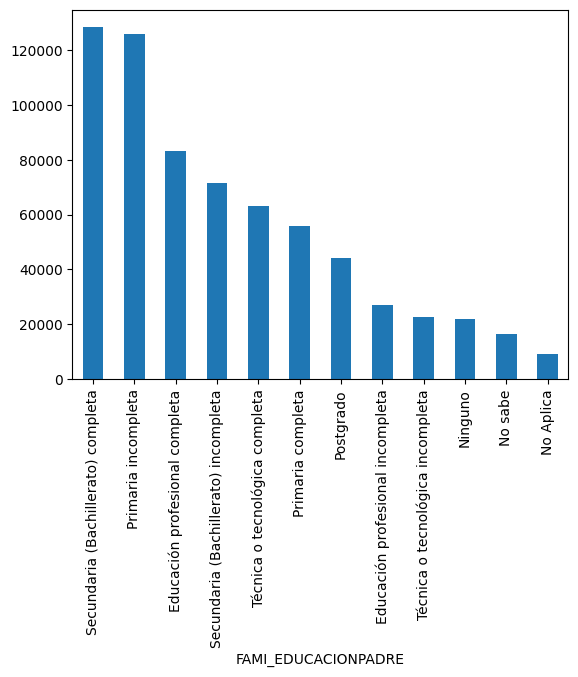

In [8]:
z.FAMI_EDUCACIONPADRE.value_counts().plot(kind='bar')

<Axes: xlabel='ESTU_HORASSEMANATRABAJA'>

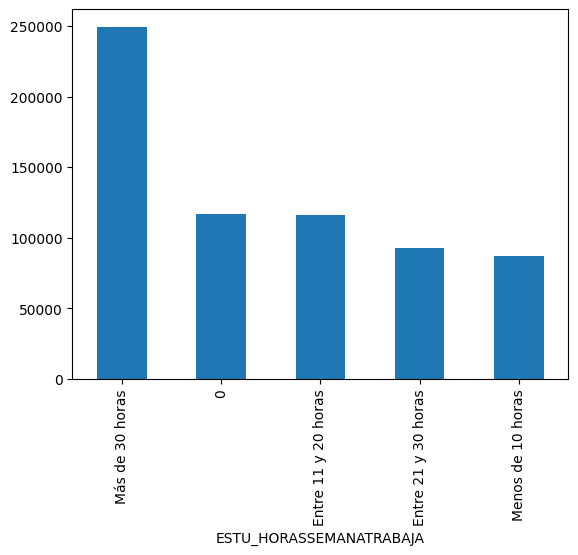

In [10]:
z.ESTU_HORASSEMANATRABAJA.value_counts().plot(kind='bar')

## Inspect visually if these two columns have distinctive behaviour with respect to what we want to predict

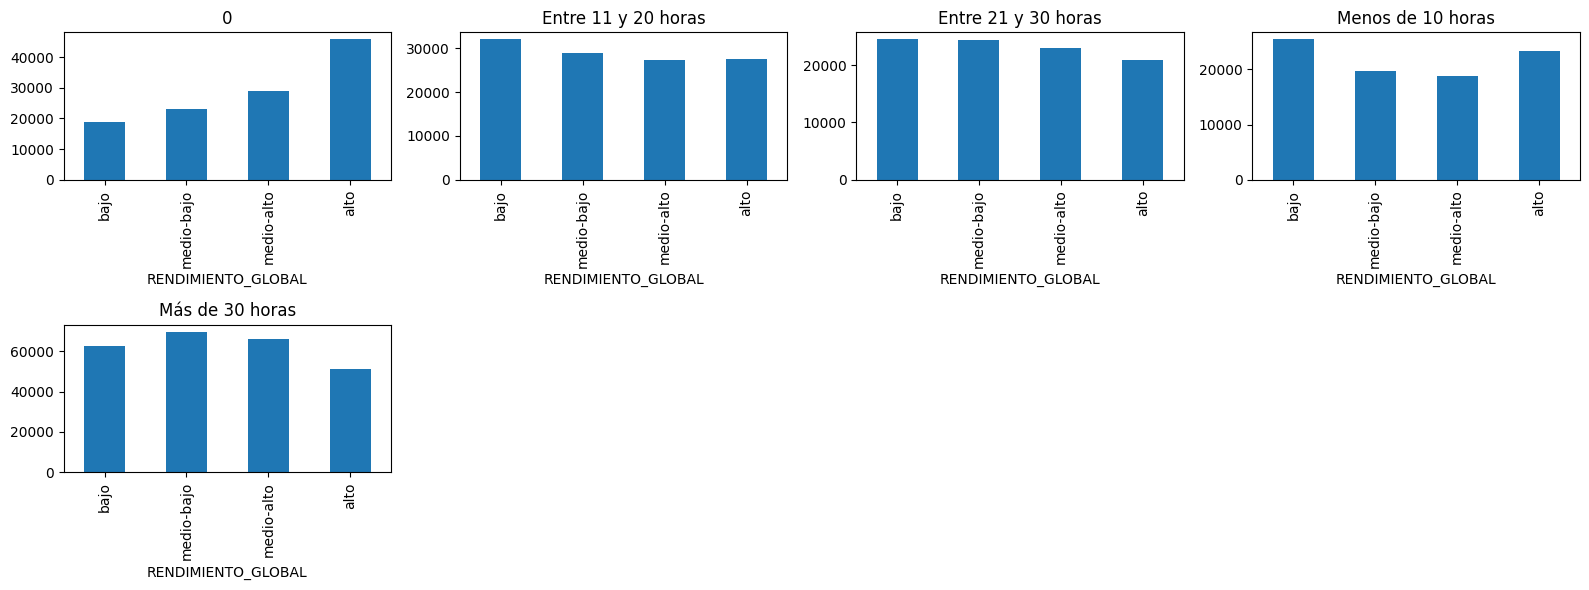

In [12]:
from rlxutils import subplots
import matplotlib.pyplot as plt

c = sorted(z.ESTU_HORASSEMANATRABAJA.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.ESTU_HORASSEMANATRABAJA==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

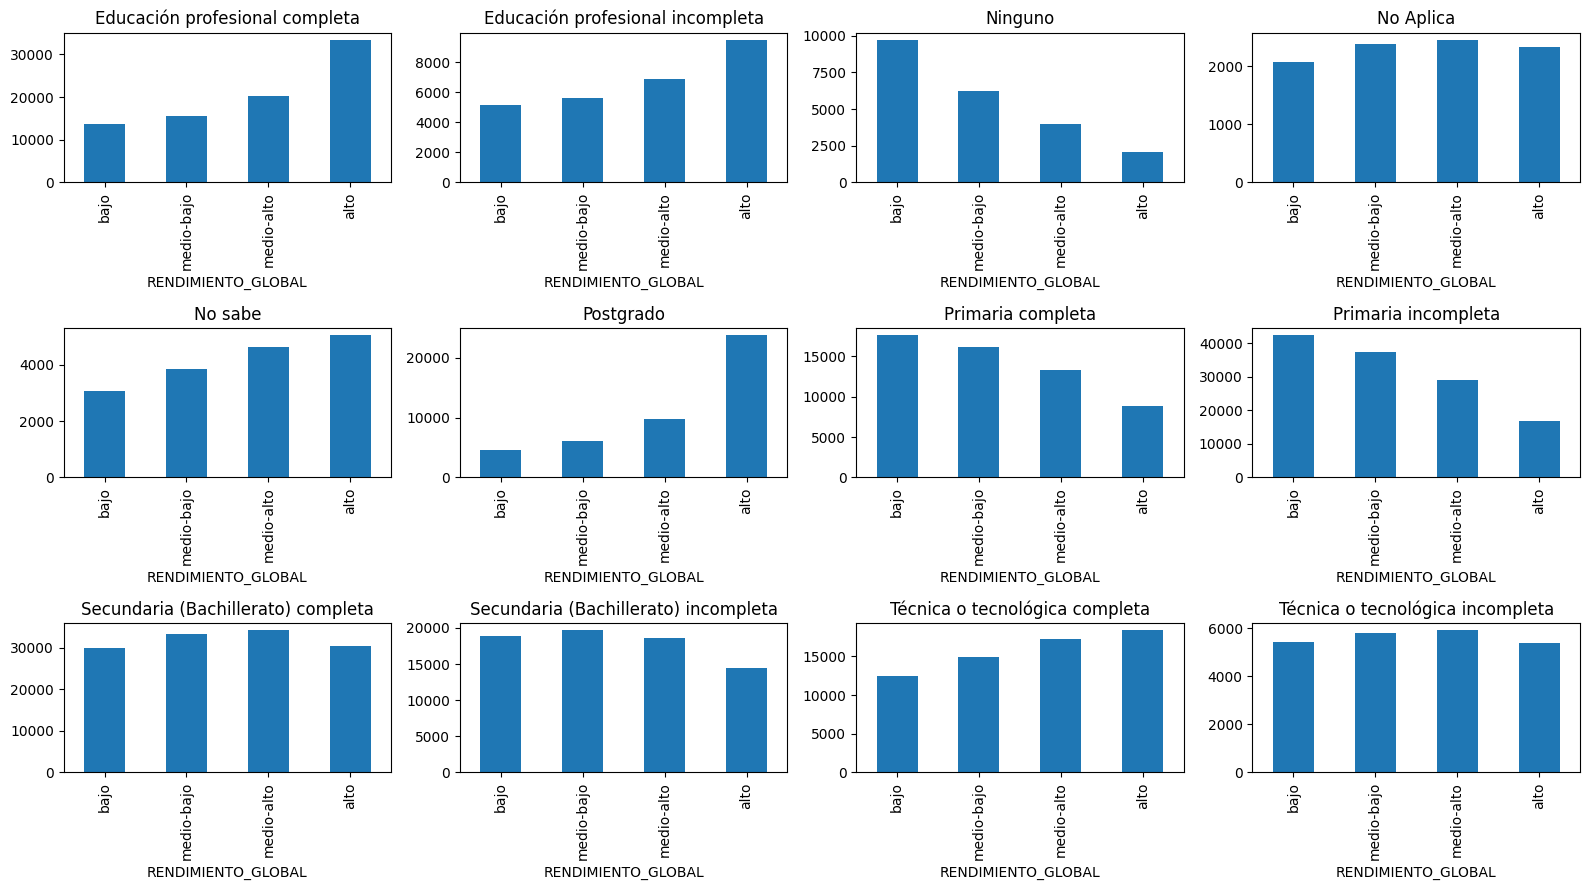

In [13]:
c = sorted(z.FAMI_EDUCACIONPADRE.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.FAMI_EDUCACIONPADRE==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

## Basic cleanup

considering that we have in total 692K data items, we have realatively few missing values on each column

In [14]:
sum(z.FAMI_EDUCACIONPADRE.isna()), sum(z.ESTU_HORASSEMANATRABAJA.isna())

(23178, 30857)

we will substitute `nan` values with a preset symbol to mark them

In [18]:
z.FAMI_EDUCACIONPADRE.values[z.FAMI_EDUCACIONPADRE.isna()] = 'no info'
z.ESTU_HORASSEMANATRABAJA.values[z.ESTU_HORASSEMANATRABAJA.isna()] = 'no info'
sum(z.FAMI_EDUCACIONPADRE.isna()), sum(z.ESTU_HORASSEMANATRABAJA.isna())

(0, 0)

### Cleaning `ESTU_VALORMATRICULAUNIVERSIDAD`

we convert `ESTU_VALORMATRICULAUNIVERSIDAD` to a **continuous** value since the ordering makes sense and we would like models to have a chance to capture it.

observe we assign `no info` to -1, which is somewhat artificial in this case

In [19]:
import numpy as np
import pandas as pd

# Mapa de conversión
hours_map = {
    'Menos de 10 horas': 5.0,
    '0': 0,  # '0' representa "No trabaja"
    'Más de 30 horas': 35.0,
    'Entre 21 y 30 horas': 25.5,
    'Entre 11 y 20 horas': 15.5,
    'no info': -1  # Para valores sin información
}

# Reemplazar valores de forma segura usando map y rellenar NaN
z['ESTU_HORASSEMANATRABAJA'] = z['ESTU_HORASSEMANATRABAJA'].map(hours_map)

# Rellena NaN con un valor específico si lo deseas (por ejemplo, -1)
z['ESTU_HORASSEMANATRABAJA'] = z['ESTU_HORASSEMANATRABAJA'].fillna(-1)

# Ver el conteo de los valores transformados
print(z['ESTU_HORASSEMANATRABAJA'].value_counts())

ESTU_HORASSEMANATRABAJA
 35.0    249352
 0.0     116550
 15.5    115857
 25.5     92693
 5.0      87191
-1.0      30857
Name: count, dtype: int64


### Cleaning `FAMI_EDUCACIONMADRE`

observe that for `FAMI_EDUCACIONMADRE` there could be many choices on how to deal with missing data

- leave it as it is
- unite `no info`, `No sabe` , `No Aplica` into a single symbol
- etc.

since there are not so many `No sabe`, `No aplica` probably they wont have much effect on the final result so we will unite them into a single value so that there are not so many columns in the one hot encoding


In [20]:
z = z.copy()
z.FAMI_EDUCACIONPADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in z.FAMI_EDUCACIONPADRE.values]

In [21]:
z.FAMI_EDUCACIONPADRE.value_counts()

,count
FAMI_EDUCACIONPADRE,
Secundaria (Bachillerato) completa,128289
Primaria incompleta,125675
Educación profesional completa,83117
Secundaria (Bachillerato) incompleta,71654
Técnica o tecnológica completa,62995
Primaria completa,55958
no info,48999
Postgrado,44169
Educación profesional incompleta,27084


first we create the onehot mapping

In [22]:
x = z.FAMI_EDUCACIONPADRE.values
FAMI_EDUCACIONPADRE_vals = sorted(np.unique(x))
FAMI_EDUCACIONPADRE_onehot_vals = {val: np.eye(len(FAMI_EDUCACIONPADRE_vals))[i] for i,val in enumerate(FAMI_EDUCACIONPADRE_vals)}
FAMI_EDUCACIONPADRE_onehot_vals

{'Educación profesional completa': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Educación profesional incompleta': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Ninguno': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Postgrado': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'Primaria completa': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'Primaria incompleta': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'Secundaria (Bachillerato) completa': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'Secundaria (Bachillerato) incompleta': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'Técnica o tecnológica completa': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'Técnica o tecnológica incompleta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'no info': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}

In [23]:
FAMI_EDUCACIONPADRE_onehot_enc = np.r_[[FAMI_EDUCACIONPADRE_onehot_vals[i] for i in z.FAMI_EDUCACIONPADRE]]
FAMI_EDUCACIONPADRE_onehot_enc

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
FAMI_EDUCACIONPADRE_df = pd.DataFrame(FAMI_EDUCACIONPADRE_onehot_enc, columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in FAMI_EDUCACIONPADRE_onehot_vals])
FAMI_EDUCACIONPADRE_df

,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Ninguno,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__no info
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
692495,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692496,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
692497,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692498,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


and we assemble everything into a single dataframe, removing the original `FAMI_EDUCACIONMADRE` column.

we now have 13 columns ... why?


In [25]:
z = pd.concat([FAMI_EDUCACIONPADRE_df, z], axis=1).drop('FAMI_EDUCACIONPADRE', axis=1)
z.shape

(692500, 13)

In [26]:
z.head()

,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Ninguno,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__no info,ESTU_HORASSEMANATRABAJA,RENDIMIENTO_GLOBAL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,medio-alto
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,bajo
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,35.0,bajo
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,alto
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.5,medio-bajo


## convert target (prediction) column into discrete values

now everything in our dataset is **numeric**!!!

In [27]:
y_col = 'RENDIMIENTO_GLOBAL'

rmap = {'alto': 3, 'bajo':0, 'medio-bajo':1, 'medio-alto':2}
z[y_col] = [rmap[i] for i in z[y_col]]
z.head()

,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Ninguno,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__no info,ESTU_HORASSEMANATRABAJA,RENDIMIENTO_GLOBAL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,35.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.5,1


## build `X` and `y` for training a model

observe we sort columns to make sure we always get the same ordering

In [28]:
z = z[sorted(z.columns)]

X = z[[c for c in z.columns if c!=y_col]].values
y = z[y_col].values
X.shape, y.shape

((692500, 12), (692500,))

## split into train and test

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.8)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((554000, 12), (138500, 12), (554000,), (138500,))

## Make a linear model for classification

train model

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(Xtr, ytr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

get predictions

In [32]:
preds_tr = lr.predict(Xtr)
preds_ts = lr.predict(Xts)

In [33]:
print (preds_tr[:10])
print (preds_ts[:10])

[0 2 3 3 1 3 0 0 3 0]
[0 0 1 3 1 3 0 3 0 1]


get accuracy and confusion matrices

In [34]:
np.mean(preds_tr==ytr), np.mean(preds_ts==yts)

(0.33351083032490975, 0.3323249097472924)

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# normalize by class
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

observe how each row in the confusion matrix adds up to 1. What does this mean?

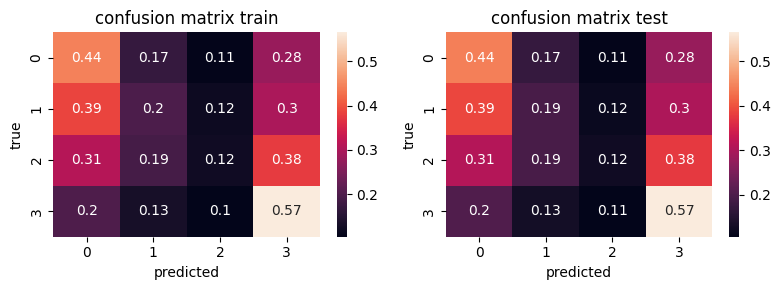

In [37]:
import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

## is the column `FAMI_EDUCACIONMADRE` really contributing?

remove it and compare scores

In [38]:
zh = z[['ESTU_HORASSEMANATRABAJA', y_col]]

X = zh[[c for c in zh.columns if c!=y_col]].values
y = zh[y_col].values
X.shape, y.shape

((692500, 1), (692500,))

In [39]:
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.8)
lr_small = LogisticRegression()
lr_small.fit(Xtr, ytr)

LogisticRegression()

In [40]:
preds_tr = lr_small.predict(Xtr)
preds_ts = lr_small.predict(Xts)
np.mean(preds_tr==ytr), np.mean(preds_ts==yts)

(0.28482671480144406, 0.28696750902527074)

where is it helping?

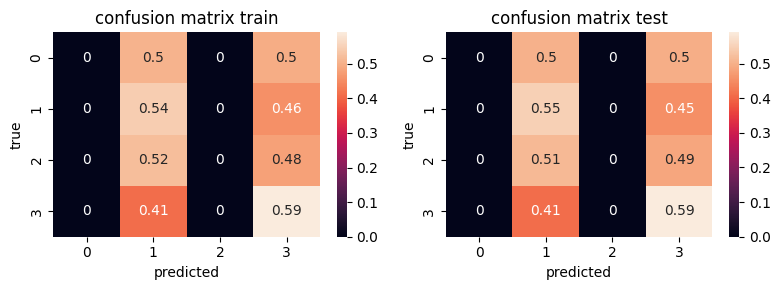

In [41]:
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# normalize by class
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

## We keep the first model, now we apply the same procedure to `test.csv`

observe:
- there is no `RENDIMIENTO_GLOBAL` column
- we must keep the IDs so that we can create properly the submission file

In [42]:
zt = pd.read_csv("test.csv")
zt

,Unnamed: 0,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO
0,0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Primaria completa,Si
1,1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Técnica o tecnológica completa,No
2,2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa,No
3,3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Primaria incompleta,No
4,4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No
...,...,...,...,...,...,...,...,...,...,...,...,...
296781,296781,496981,20195,ADMINISTRACION DE EMPRESAS,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 1,Si,Primaria incompleta,Primaria incompleta,Si
296782,296782,209415,20183,DERECHO,META,Entre 1 millón y menos de 2.5 millones,0,Estrato 4,Si,Educación profesional completa,Educación profesional completa,No
296783,296783,239074,20212,DERECHO,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Educación profesional completa,No
296784,296784,963852,20195,INGENIERIA AERONAUTICA,ANTIOQUIA,Entre 5.5 millones y menos de 7 millones,Entre 11 y 20 horas,Estrato 3,Si,Educación profesional completa,Educación profesional completa,No


In [43]:
zt_ids = zt['ID'].values
zt = zt[['FAMI_EDUCACIONPADRE', 'ESTU_HORASSEMANATRABAJA']]
print ("shape of loaded dataframe", zt.shape)
zt.head()

shape of loaded dataframe (296786, 2)


,FAMI_EDUCACIONPADRE,ESTU_HORASSEMANATRABAJA
0,Técnica o tecnológica completa,Menos de 10 horas
1,Secundaria (Bachillerato) completa,Entre 21 y 30 horas
2,Secundaria (Bachillerato) incompleta,0
3,Primaria incompleta,Entre 21 y 30 horas
4,Secundaria (Bachillerato) completa,Entre 11 y 20 horas


In [44]:
zt.FAMI_EDUCACIONPADRE.values[zt.FAMI_EDUCACIONPADRE.isna()] = 'no info'
zt.ESTU_HORASSEMANATRABAJA.values[zt.ESTU_HORASSEMANATRABAJA.isna()] = 'no info'


In [46]:
zt = zt.copy()
zt.ESTU_HORASSEMANATRABAJA = np.r_[[hours_map[i] for i in zt.ESTU_HORASSEMANATRABAJA]]


In [47]:
zt.FAMI_EDUCACIONPADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in zt.FAMI_EDUCACIONPADRE.values]
FAMI_EDUCACIONPADRE_onehot_enc = np.r_[[FAMI_EDUCACIONPADRE_onehot_vals[i] for i in zt.FAMI_EDUCACIONPADRE]]
FAMI_EDUCACIONPADRE_df = pd.DataFrame(FAMI_EDUCACIONPADRE_onehot_enc, columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in FAMI_EDUCACIONPADRE_onehot_vals])
zt = pd.concat([FAMI_EDUCACIONPADRE_df, zt], axis=1).drop('FAMI_EDUCACIONPADRE', axis=1)
zt.shape

(296786, 12)

In [48]:
zt

,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Ninguno,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__no info,ESTU_HORASSEMANATRABAJA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25.5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25.5
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15.5
...,...,...,...,...,...,...,...,...,...,...,...,...
296781,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0
296782,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296783,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,35.0
296784,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.5


create `X` array and predict

In [49]:
X_test_data = zt[sorted(zt.columns)].values
X_test_data.shape

(296786, 12)

In [50]:
preds_test_data = lr.predict(X_test_data)

## prepare submission

first, map back the predictions to textual values

In [51]:
# inverse mapping
rmapi = {v:k for k,v in rmap.items()}
text_preds_test_data = [rmapi[i] for i in preds_test_data]


In [52]:
# create dataframe

submission = pd.DataFrame([zt_ids, text_preds_test_data], index=['ID', 'RENDIMIENTO_GLOBAL']).T
submission

,ID,RENDIMIENTO_GLOBAL
0,550236,alto
1,98545,medio-alto
2,499179,bajo
3,782980,bajo
4,785185,medio-alto
...,...,...
296781,496981,bajo
296782,209415,alto
296783,239074,medio-bajo
296784,963852,alto


In [53]:
# save to file ready to submit
submission.to_csv("my_submission.csv", index=False)

In [54]:
!head my_submission.csv

ID,RENDIMIENTO_GLOBAL
550236,alto
98545,medio-alto
499179,bajo
782980,bajo
785185,medio-alto
58495,bajo
705444,bajo
557548,alto
519909,medio-alto


In [55]:
submission.shape

(296786, 2)

## Send your submission to Kaggle

You must **join the competition** first

In [56]:
!kaggle competitions submit -c udea-ai4eng-20242 -f my_submission.csv -m "raul ramos submission with linear model"

100% 3.84M/3.84M [00:00<00:00, 15.7MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia

## Things you can try

- other models (svm, random forest, gaussian, etc.)
- different parameters in the models (like `gamma` for svm, or `max_depth` for random forests). see the doc of each model in `sklearn`.
- use different preprocessing and cleaning methods for different columns
- create new columns manually, for instance,
    - group `ESTU_PRGM_ACADEMICO` into areas of knowlege (engineering, social sciences, etc.)
    - do some operation between columns (multiply, concatenate, etc.)
- integrate external data as new columns, for instance, economic data from each department in Colombia, for each different year, etc.
